In [ ]:
!pip install torch torchvision matplotlib scikit-learn

Epoch 1, Train Loss: 0.2402, Val Loss: 0.0748, Val Acc: 0.9757
Epoch 2, Train Loss: 0.0701, Val Loss: 0.0520, Val Acc: 0.9816
Epoch 3, Train Loss: 0.0501, Val Loss: 0.0319, Val Acc: 0.9896
Epoch 4, Train Loss: 0.0392, Val Loss: 0.0330, Val Acc: 0.9884
Epoch 5, Train Loss: 0.0308, Val Loss: 0.0341, Val Acc: 0.9883
Epoch 6, Train Loss: 0.0291, Val Loss: 0.0316, Val Acc: 0.9894
Epoch 7, Train Loss: 0.0240, Val Loss: 0.0457, Val Acc: 0.9861
Epoch 8, Train Loss: 0.0207, Val Loss: 0.0329, Val Acc: 0.9901
Epoch 9, Train Loss: 0.0178, Val Loss: 0.0327, Val Acc: 0.9901
Epoch 10, Train Loss: 0.0177, Val Loss: 0.0361, Val Acc: 0.9896

Accuracy: 0.9896
Precision: 0.9897
Recall: 0.9896
F1: 0.9896


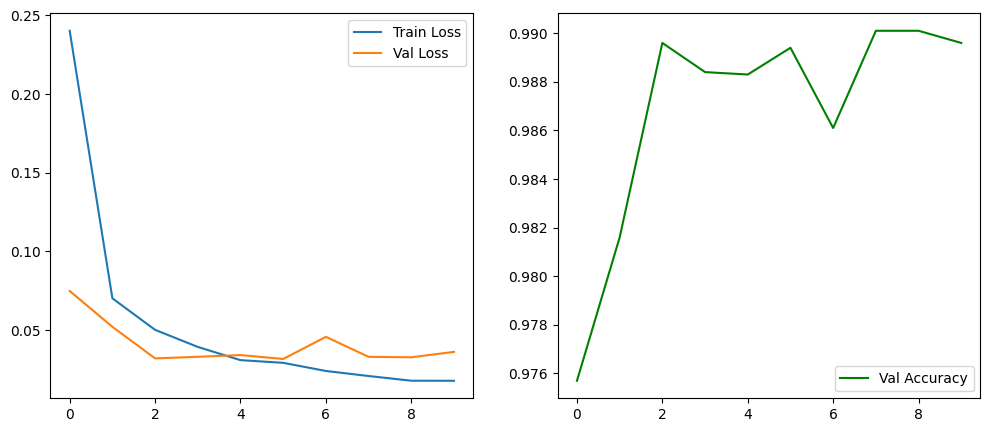

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = DataLoader(datasets.MNIST('data', True, transform, download=True), batch_size=64, shuffle=True)
test_loader = DataLoader(datasets.MNIST('data', False, transform), batch_size=64)

# Train
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(10):
    # Train
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
    
    # Validate
    model.eval()
    val_loss = 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    val_losses.append(val_loss/len(test_loader))
    val_accuracies.append(accuracy_score(all_labels, all_preds))
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Final metrics
print(f'\nAccuracy: {accuracy_score(all_labels, all_preds):.4f}')
print(f'Precision: {precision_score(all_labels, all_preds, average="weighted"):.4f}')
print(f'Recall: {recall_score(all_labels, all_preds, average="weighted"):.4f}')
print(f'F1: {f1_score(all_labels, all_preds, average="weighted"):.4f}')

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.legend()
plt.show()